In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

import pandas_datareader as pdr
import yfinance as yf
from statsmodels.tsa.stattools import coint
import requests
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import datetime as dt
import pandas_datareader as web
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# %matplotlib inline
# Load your preprocessed dataset
# Replace 'data.csv' with your own dataset file
#data = pd.read_csv('data.csv')

start = dt.datetime(2017, 1, 1)
end = dt.datetime.now()

crypto_assets = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD', 'XRP-USD', 
                 'SOL1-USD', 'LUNA1-USD', 'DOGE-USD', 'SHIB-USD', 'ADA-USD', 'LINK-USD', 
                 'AVAX-USD', 'MATIC-USD', 'SUSHI-USD', 'ALGO-USD']

currency_assets = ['EURUSD=X', 'GBPUSD=X', 'JPY=X', 'AUDUSD=X', 'CAD=X', 'CHF=X', 'CNY=X']

assetsDF = pd.DataFrame()

for asset in crypto_assets + currency_assets:
    ticker = yf.Ticker(asset)
    data = ticker.history(start=start, end=end)
    data['Symbol'] = asset
    assetsDF = pd.concat([assetsDF, data])

assetsDF = assetsDF.dropna()
assetsDF
assetsDF = assetsDF.reset_index()
assetsDF

data = assetsDF[['Date', 'Symbol', 'Close']].pivot(index='Date', columns='Symbol', values='Close')
data = data[['BTC-USD', 'ETH-USD']]
data = data.dropna()
data

Symbol,BTC-USD,ETH-USD
Date,,
2017-11-09 00:00:00+00:00,7143.580078,320.884003
2017-11-10 00:00:00+00:00,6618.140137,299.252991
2017-11-11 00:00:00+00:00,6357.600098,314.681000
2017-11-12 00:00:00+00:00,5950.069824,307.907990
2017-11-13 00:00:00+00:00,6559.490234,316.716003
...,...,...
2023-04-14 00:00:00+00:00,30485.699219,2101.635498
2023-04-15 00:00:00+00:00,30318.496094,2092.466797
2023-04-16 00:00:00+00:00,30315.355469,2120.005859


In [46]:
# Assuming 'Close' is the target variable, and 'data' is a DataFrame
target_variable = 'Close'
time_steps = 100  # Adjust this based on your dataset and problem
# data.dropna()
# Scale your data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


data_scaled


array([[0.06073083, 0.0500395 ],
       [0.05256296, 0.0454642 ],
       [0.0485129 , 0.04872747],
       ...,
       [0.42093216, 0.43058221],
       [0.40740333, 0.42132565],
       [0.40914153, 0.42444226]])

In [47]:
# Create train and test sets, assuming you have already split your data
X_train, y_train = [], []
X_test, y_test = [], []

# Replace 'train_data' and 'test_data' with your own train and test sets
train_size = int(len(data_scaled) * 0.7)

train_data = data_scaled[:train_size]
test_data = data_scaled[train_size - time_steps:]

# Create input and output sequences for training and testing
for i in range(time_steps, len(train_data)):
    X_train.append(train_data[i - time_steps:i])
    y_train.append(train_data[i, 0])
for i in range(time_steps, len(test_data)):
    X_test.append(test_data[i - time_steps:i])
    y_test.append(test_data[i, 0])

# Convert lists to numpy arrays and then to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create PyTorch Dataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_size = X_train.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)


# Train the model
num_epochs = 100

for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0081
Epoch [2/100], Loss: 0.0013
Epoch [3/100], Loss: 0.0015
Epoch [4/100], Loss: 0.0015
Epoch [5/100], Loss: 0.0046
Epoch [6/100], Loss: 0.0014
Epoch [7/100], Loss: 0.0004
Epoch [8/100], Loss: 0.0015
Epoch [9/100], Loss: 0.0016
Epoch [10/100], Loss: 0.0003
Epoch [11/100], Loss: 0.0023
Epoch [12/100], Loss: 0.0036
Epoch [13/100], Loss: 0.0001
Epoch [14/100], Loss: 0.0012
Epoch [15/100], Loss: 0.0005
Epoch [16/100], Loss: 0.0007
Epoch [17/100], Loss: 0.0012
Epoch [18/100], Loss: 0.0005
Epoch [19/100], Loss: 0.0002
Epoch [20/100], Loss: 0.0010
Epoch [21/100], Loss: 0.0023
Epoch [22/100], Loss: 0.0008
Epoch [23/100], Loss: 0.0002
Epoch [24/100], Loss: 0.0003
Epoch [25/100], Loss: 0.0004
Epoch [26/100], Loss: 0.0012
Epoch [27/100], Loss: 0.0001
Epoch [28/100], Loss: 0.0005
Epoch [29/100], Loss: 0.0006
Epoch [30/100], Loss: 0.0007
Epoch [31/100], Loss: 0.0013
Epoch [32/100], Loss: 0.0002
Epoch [33/100], Loss: 0.0009
Epoch [34/100], Loss: 0.0013
Epoch [35/100], Loss: 0

In [29]:
# Test the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)

# Assuming 'Date' is the first column, 'BTC-USD' is the target variable, and 'ETH-USD' is the feature
target_variable = 'BTC-USD'
feature_variable = 'ETH-USD'

# Scale your data using MinMaxScaler for the target variable and features
target_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(0, 1))

target_data = target_scaler.fit_transform(data[target_variable].values.reshape(-1, 1))
feature_data = feature_scaler.fit_transform(data[feature_variable].values.reshape(-1, 1))

# Combine the target variable and features into a single scaled dataset
data_scaled = np.hstack((target_data, feature_data))

# ... (rest of the code for creating input and output sequences, train and test sets)

# Convert test_outputs back to the original scale
test_outputs = test_outputs.numpy()
test_outputs_unscaled = target_scaler.inverse_transform(test_outputs)

# Convert y_test back to the original scale
y_test = y_test.numpy()
y_test_unscaled = target_scaler.inverse_transform(y_test)





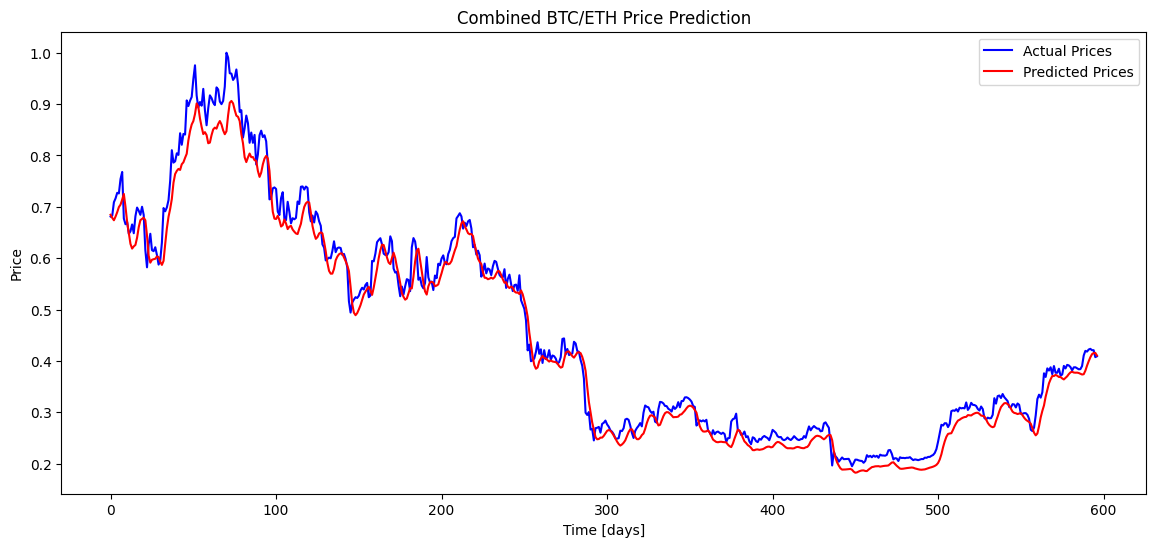

In [33]:
# Visualize the predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test[:, 0], label='Actual Prices', color='blue')
plt.plot(test_outputs[:, 0], label='Predicted Prices', color='red')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.title('Combined BTC/ETH Price Prediction')
plt.legend()
plt.show()

In [48]:
# Test the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Reshape y_test to match the dimensions of test_outputs
y_test = y_test.view(-1, 1)

# Calculate the mean squared error
test_loss = criterion(test_outputs, y_test)
print(f'Test loss: {test_loss.item():.4f}')

# Convert test_outputs back to the original scale
test_outputs = test_outputs.numpy()
test_outputs_unscaled = target_scaler.inverse_transform(test_outputs)

# Convert y_test back to the original scale
y_test = y_test.numpy()
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((test_outputs_unscaled - y_test_unscaled)**2))
print(f'RMSE: {rmse:.4f}')




Test loss: 0.0005
RMSE: 1477.9862


<ipython-input-48-3dcc32503967>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


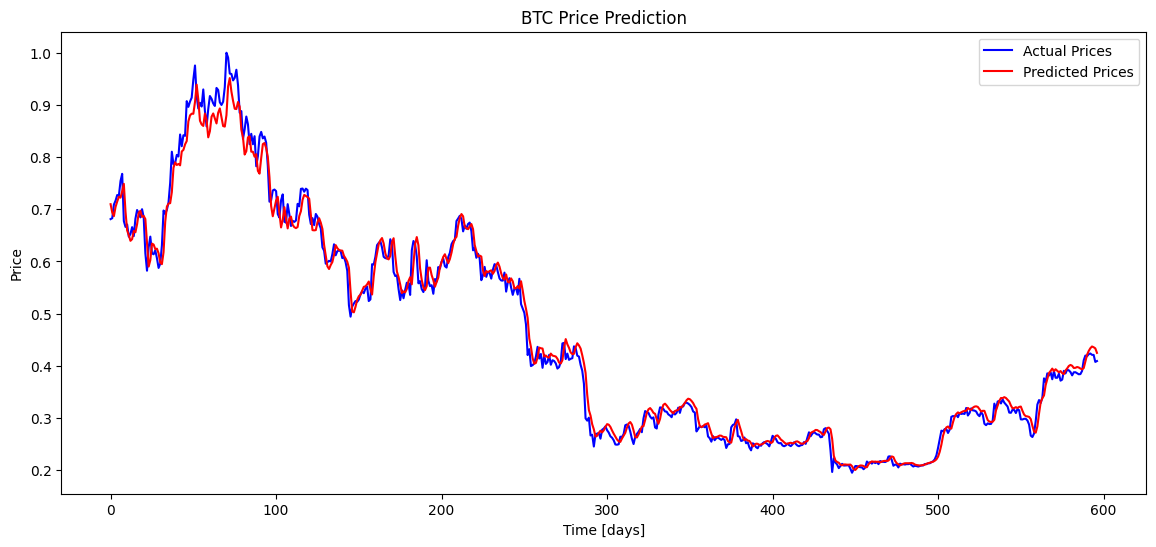

In [51]:
plt.figure(figsize=(14, 6))
plt.plot(y_test[:, 0], label='Actual Prices', color='blue')
plt.plot(test_outputs[:, 0], label='Predicted Prices', color='red')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()